# TP1: Análisis Básico

Doce atletas entrenan para una competencia de 100m llanos. El entrenamiento se realiza aún en condiciones climáticas adversas. El archivo `tiempos.txt` contiene los tiempos en segundos de cada atleta para un entrenamiento en un día soleado, en un día nublado y en un día de lluvia intensa.

Utilizando el lenguaje Python, procedimos a analizar los datos. Como primer paso, importamos los paquetes a utilizar.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## 1. Datos

Cargamos los datos y los visualizamos.

In [4]:
# Atleta tiempo_sol tiempo_nublado tiempo_lluvia
datos = np.loadtxt('tiempos.txt', skiprows=1)

In [18]:
pd.DataFrame(datos[:,1:], columns=['sol', 'nublado', 'lluvia'], index=datos[:,0]).T

,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0
sol,11.1,13.0,16.1,14.5,12.0,11.0,15.1,14.4,16.1,17.0,12.2,14.4
nublado,11.3,12.8,16.0,14.1,12.5,11.6,14.6,14.2,16.1,16.7,12.4,14.1
lluvia,19.4,18.2,19.0,18.9,19.1,18.7,18.9,19.9,18.5,19.2,18.8,19.2


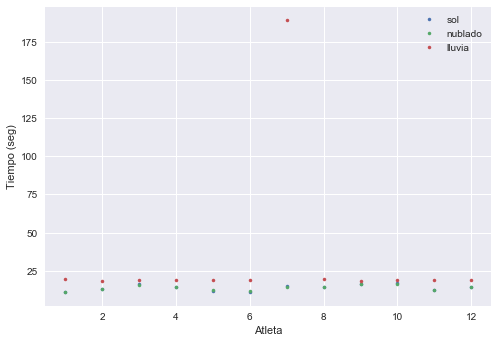

In [5]:
plt.plot(datos[:,0], datos[:,1], '.', label='sol')
plt.plot(datos[:,0], datos[:,2], '.', label='nublado')
plt.plot(datos[:,0], datos[:,3], '.', label='lluvia')
plt.xlabel('Atleta')
plt.ylabel('Tiempo (seg)')
plt.legend()
plt.show()

En lluvia tenemos un outlier. Vemos que parecería ser porque faltó el punto decimal. Lo agregamos.

In [6]:
datos[6, 3] = datos[6, 3] / 10.

In [7]:
sol, nublado, lluvia = datos[:,1], datos[:, 2], datos[:, 3]

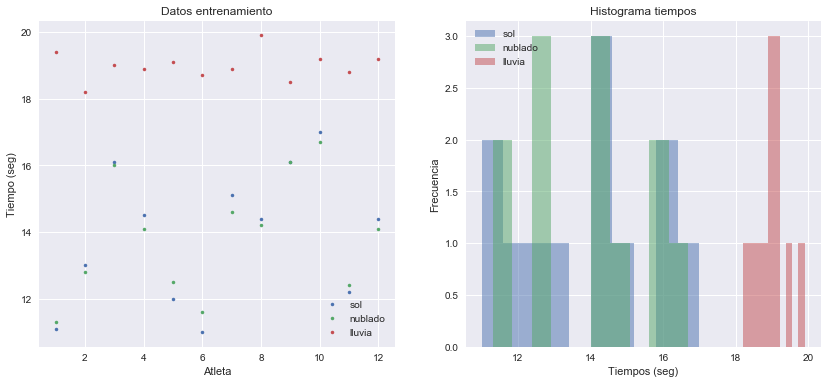

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
plt.sca(axs[0])
plt.plot(datos[:,0], datos[:,1], '.', label='sol')
plt.plot(datos[:,0], datos[:,2], '.', label='nublado')
plt.plot(datos[:,0], datos[:,3], '.', label='lluvia')
plt.xlabel('Atleta')
plt.ylabel('Tiempo (seg)')
plt.title('Datos entrenamiento')
plt.legend()

plt.sca(axs[1])
plt.hist(sol, alpha=0.5, label='sol')
plt.hist(nublado, alpha=0.5, label='nublado')
plt.hist(lluvia, alpha=0.5, label='lluvia')
plt.title('Histograma tiempos')
plt.xlabel('Tiempos (seg)')
plt.ylabel('Frecuencia')
plt.legend()

En una primera inspección se observa que los datos correspondientes a los días soleados y nublados se comportan de manera similar. No parecería que el tiempo de los atletas en días nublados sea más lento que en soleados. Si se ve que en días de lluviosos los tiempos son más largos. También se ve que en días de lluvia hay menos varianza en el tiempo de los atletas.

## 2. Tests

Aplicamos distintos test sobre los datos para evaluar diferentes hipótesis sobre los datos.

### 2.1. Los atletas son más lentos en días de lluvia que en días soleados.

Este enunciado puede analizarse desde varias perspectivas. Un caso sería analizar si los tiempos en día de lluvia son en promedio mayor que en los días soleados.

Con esta idea podemos plantear como hipótesis nula que los tiempos de ambos conjuntos de datos (sol, lluvia) tienen el mismo promedio. Podemos evaluar esta hipótesis mediante un t-test de dos muestras. En particular, como los datos están apareados por cada atleta podemos aprovechar para hacer el t-test de muestras apareadas, que es más robusto.

### Hipótesis del t-test

Consideramos entonces dos variables: 

* $\mathcal{X}_{sol}$: muestra de tiempos de los atletas en días soleados 
* $\mathcal{X}_{lluvia}$: muestra de tiempos de los atletas en días de lluvia 

Para poder aplicar el t-test para estas dos distribuciones tenemos las siguientes hipótesis:

1. $\mathcal{X}_{sol}$ y $\mathcal{X}_{lluvia}$ se distribuyen de forma normal. 
2. Las muestras de $\mathcal{X}_{sol}$ y $\mathcal{X}_{lluvia}$ son independientes cada una. 
3. Ambas distribuciones tienen igual varianza.
4. Ambas muestras tienen la misma cantidad de datos.
5. Para un test de muestras apareadas, es ideal observar si la diferencia en los valores apareados se distribuye normalmente.

Verificamos las hipótesis.

#### Hipótesis 1

Hacemos un KS test para ver si las muestras provienen de una distribución normal. Como el test evalúa las muestras contra una normal standard, es necesario estandarizar las muestras.

In [33]:
t_sol, p_sol = sp.stats.kstest((sol - sol.mean())/sol.std(), 'norm')
t_lluvia, p_lluvia = sp.stats.kstest((lluvia - lluvia.mean())/lluvia.std(), 'norm')
pd.DataFrame({'sol':{'t': t_sol, 'p': p_sol}, 'lluvia': {'t': t_lluvia, 'p': p_lluvia}})

,lluvia,sol
p,0.980328,0.814452
t,0.135442,0.183383


En ambas distribuciones, el p-valor del test no llega a la significancia (> 0.05). Si miramos el histograma en la sección **Datos**, los tiempos en sol no parecerían ser normales. En cambio, los de lluvia podrían serlo. Sería necesario tener más muestras para cada caso. A pesar de esto, seguimos adelante con el uso del test.

#### Hipótesis 2

Esto es válido por la característica de las mediciones, donde cada atleta corre independientemente de los otros.

#### Hipótesis 3

Para evaluar igualdad de varianza utilizamos el test de [Levene](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.levene.html), ya que se lo recomienda cuando no hay seguridad de normalidad de las distribuciones.

In [36]:
var_t, var_p = sp.stats.levene(sol, lluvia)
print('t = {:.4f}, p = {:.4f}'.format(var_t, var_p))

t = 13.0840, p = 0.0015


Por el resultado del p-valor, debemos descartar la hipótesis nula y asumir que ambas muestras tienen distinta varianza.

#### Hipótesis 4

Se cumple por los datos.

#### Hipótesis 5

Evaluamos normalidad de las distancias a pares con un kstest.

In [53]:
d = lluvia - sol
print(sp.stats.kstest((d-d.mean())/d.std(), 'norm'))

KstestResult(statistic=0.11611504165177383, pvalue=0.99695893157033921)


Mediante el resultado del test no podemos descartar que la distancia entre valores sea normal.

Habiendo hecho el análisis de las hipótesis, evaluamos la hipótesis nula de igual varianza para ambas distribuciones utilizando un t-test de dos muestras apareadas.

#### Evaluación

Realizamos el test de muestras apareadas pero dado que tuvimos que descartar la hipótesis de que ambas muestras tienen igual media, realizamos también un test de Welsh (que no requiere esta hipótesis).

In [61]:
mean_rel = sp.stats.ttest_rel(lluvia, sol)
mean_welsh = sp.stats.ttest_ind(lluvia, sol, equal_var=False)
pd.DataFrame([mean_rel, mean_welsh], index=['Rel', 'Welsh'])

,statistic,pvalue
Rel,8.576228,0.000003
Welsh,8.482840,0.000002


En ambos casos el p-valor es muy bajo, lo cual nos permite descartar la hipótesis nula donde ambas distribuciones tienen igual media.

En particular, dado que en ambos casos el estadístico representa la diferencia entre los días de lluvia y los días de sol y el estadístico es positivo, podemos concluir que en días de lluvia los atletas son más lentos.



Para fortalecer la conclusión alcanzada realizamos un test de permutaciones para el estadístico $\bar{\mathcal{X}}_{lluvia}$ - $\bar{\mathcal{X}}_{lluvia}$. Esto es, queremos rechazar la hipótesis nula donde los tiempos observados para lluvia y sol son indistintos del clima. Si ese fuera el caso, generando muestras con las etiquetas del clima cambiadas, veríamos que el estadístico original se acomoda bien a la distribución creada.

### Test de permutaciones

In [62]:
todos =  np.concatenate((sol, lluvia))
etiquetas_sol = np.repeat('sol', sol.size)
etiquetas_lluvia = np.repeat('lluvia', lluvia.size)
etiquetas = np.concatenate((etiquetas_sol, etiquetas_lluvia))

In [64]:
print('Todos los valores con respectivas etiquetas.')
pd.DataFrame({'valores': todos, 'etiquetas':etiquetas}).T

Todos los valores con respectivas etiquetas.


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
etiquetas,sol,sol,sol,sol,sol,sol,sol,sol,sol,sol,...,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia,lluvia
valores,11.1,13,16.1,14.5,12,11,15.1,14.4,16.1,17,...,19,18.9,19.1,18.7,18.9,19.9,18.5,19.2,18.8,19.2


In [65]:
delta_0 = lluvia.mean() - sol.mean()
print('Diferencia de promedios entre lluvia y sol: {:.4f} seg'.format(delta_0))

Diferencia de promedios entre lluvia y sol: 5.0750 seg


Calculamos distribución con permutaciones.

In [66]:
deltas = []
for i in range(1000):
    etiquetas_s = np.copy(etiquetas)
    np.random.shuffle(etiquetas)
    sol_s = todos[etiquetas_s == 'sol']
    lluvia_s = todos[etiquetas_s == 'lluvia']
    delta_1 = lluvia_s.mean() - sol_s.mean()
    deltas.append(delta_1)

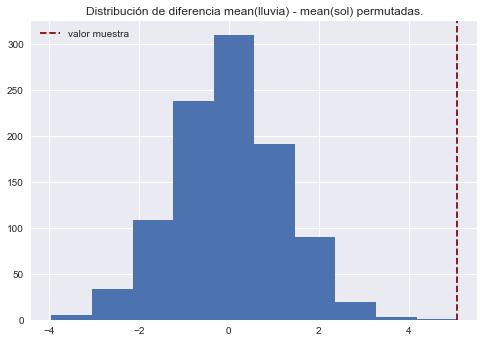

In [67]:
plt.hist(deltas)
plt.axvline(delta_0, color='darkred', linestyle='--', label='valor muestra')
plt.title(u'Distribución de diferencia mean(lluvia) - mean(sol) permutadas.')
plt.legend()

In [68]:
deltas = np.array(deltas)

In [70]:
p = np.sum(deltas > delta_0) / 1000.
print('Probabilidad de el valor de la muestra en la distribución de permutaciones: {:.4f}'.format(p))

Probabilidad de el valor de la muestra en la distribución de permutaciones: 0.0000


Viendo que es muy poco probable que la forma en que se dieron las etiquetas para los tiempos en sol y lluvia se haya originado de una distribución donde las etiquetas son independientes de los tiempos, descartamos la hipótesis nula.

    TODO: Conclusiones

### 2.2. El cielo nublado no influye en los tiempos de los atletas.
#### Hago dos tests de muestras apareadas

h0_sol = los dias nublados influyen de la misma manera que los dias soleados en el tiempo de los atletas

In [ ]:
sp.stats.ttest_rel(nublado, sol)

Debido a que se encontro un p-value de 0.688, no se puede descartar la hipotesis sugerida. El resultado del estadistico indicaria que en los dias nublados, los atletas logran tiempos menores.

h0_lluvia = los dias nublados influyen de la misma manera que los dias lluviosos en el tiempo de los atletas

In [ ]:
sp.stats.ttest_rel(nublado, lluvia)

Podemos descartar la hipotesis que los dias nublados influyen de igual modo que los lluviosos basandonos en el p-value obtenido. Es decir, la probabilidad de que los dias nublado interfieran de la misma manera que los dias con lluvia es muy baja. Pareceria que, al igual que en el test con los dias soleados, en los dias nublados, los atletas logran tiempos menores.

Comparando los resultados de ambos tests de muestras apareadas, se observa una clara diferencia entre la performance de los atletas entre los dias nublados y de lluvia. No puede decirse lo mismo respecto a los dias soleados y nublados.

    TODO: Aclaraciones
        - Ver la hipótesis para nublado o hablar de sol y nublado como igual distribuciones.
        - Hablar de hipótesis: son analogas a t-test. Como no tenemos igual varianza, usamos también KW-H-Test.
        
        https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.kruskal.html
        https://en.wikipedia.org/wiki/Kruskal%E2%80%93Wallis_one-way_analysis_of_variance

In [91]:
print("Si queremos decir que sol y nublado son muuy parecidas")
print(sp.stats.entropy(sol, nublado))
print(sp.stats.entropy(nublado, sol))
# https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html

Si queremos decir que sol y nublado son muuy parecidas
0.0003102570594
0.000312639212413


#### Test ANOVA para las tres muestras
Quiero un test que me permita comparar los tres climas, para ver si entre ellos hay alguna diferencia.

In [87]:
t, p = sp.stats.f_oneway(nublado, lluvia, sol)
't = {:.2f}, p = {}'.format(t, p)

't = 41.57, p = 9.6112634512e-10'

In [86]:
t, p = sp.stats.kruskal(nublado, lluvia, sol)
't = {:.2f}, p = {}'.format(t, p)

't = 23.39, p = 8.33978539491e-06'

Una muestra difiere del resto debido el valor pequenio de p. Tengo que saber que tipo de clima es el que causa esa diferencia. 
#### Hago ANOVA de a pares.

ANOVA nublado-sol: ambos climas influyen de la misma manera sobre los atletas.

In [ ]:
t_1, p_1 = sp.stats.f_oneway(nublado, sol)
't_1 = {:.4f}, p_1 = {}'.format(t_1, p_1)

ANOVA nublado-lluvia: ambos climas influyen de la misma manera sobre los atletas.

In [ ]:
t_2, p_2 = sp.stats.f_oneway(nublado, lluvia)
't_2 = {:.2f}, p_2 = {}'.format(t_2, p_2)

ANOVA lluvia-sol: ambos climas influyen de la misma manera sobre los atletas.

In [ ]:
t_3, p_3 = sp.stats.f_oneway(lluvia, sol)
't_3 = {:.2f}, p_3 = {}'.format(t_3, p_3)

Estudiando los valores de p obtenidos, se acepta la primer hipotesis (dias nublados y de sol influyen de igual modo). Y se descartan aquellas dos en las que se afirma los dias nublados y lluviosos y por otro lado soleados y lluviosos influyen de la misma manera sobre los atletas. El clima que provoca performances diferentes sobre los corredores es el lluvioso.

_ Conclusiones: considerando los tests realizados, no se puede concluir que los dias nublados no influyen en la performance de los corredores. Por el contrario, se observa que dicho clima influye de igual modo que los dias soleados, con el agregado de informacion (proveniente de los tests de muestras apareadas) que los atletas podrian lograr tiempos menores en dias nublados. _

### 2.3. El clima influye en la velocidad de los atletas

Teniendo en cuenta los tests ANOVA realizados en la seccion anterior, se observa que el clima que mas influye (negativamente) en la velocidad de los atletas es la lluvia. A su vez, tanto los dias nublado como soleados, influyen de manera semejante en la performance de los corredores.

_ Conclusiones: los climas influyen en la velocidad de los atletas, especialmente la lluvia hace que su performance empeore (logran tiempos mas largos en estos dias). _

### 2.4. La velocidad en dı́as de lluvia es independiente del atleta

    TODO: Correlaciones

Se puede hacer un one-sample ttest para ver si los valores de tiempos de los días de lluvia entre todos los atletas pertencen a una distribución normal con media parametrizada como el promedio de los tiempos de todos los atletas. De esta manera, la hipótesis nula sería que los tiempos de todos los atletas para días de lluvia no son independientes, si no que se encuentran vinculados por pertencer a un tipo de distribución.

In [ ]:
sp.stats.ttest_1samp(lluvia, np.mean(lluvia))

     El resultado de esa llamada siempre da (0, 1.0)

El pvalue del test da 1, por lo que no se rechaza la hipótesis nula. Los tiempos podrían pertencer a una misma distribución.

_ Conclusiones: El test estadístico realizado sobre los datos no rechaza la hipótesis nula de que las velocidades de los atletas para días de lluvia pertencen a una misma distribución normal, por lo que no pueden considerarse como independientes. _

## Consejos para el Entrenador

    TODO: Completar con discusión

#### Evaluamos si la media de diferencia de tiempos sol - lluvia por atleta se distribuye igual si permutamos los tiempos de lluvia.

h0: la diferencia de tiempos para un atleta entre sol y lluvia es independiente del atleta.

In [71]:
deltas = []
for i in range(1000):
    lluvia_s = np.copy(lluvia)
    np.random.shuffle(lluvia_s)
    delta_1 = (lluvia_s - sol).mean()
    deltas.append(delta_1)
    
delta_0 = (lluvia - sol).mean()

In [72]:
deltas = np.array(deltas)

In [73]:
print(delta_0)
print(np.std(deltas))

5.075
9.82632051172e-16


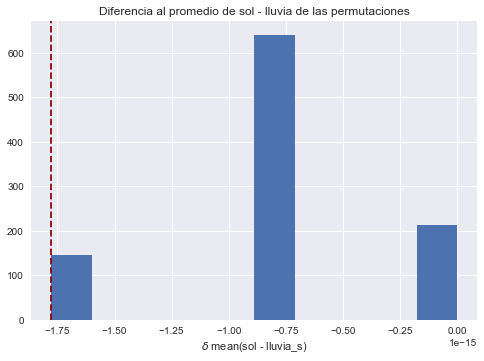

In [74]:
plt.hist(deltas - np.mean(deltas))
plt.axvline(delta_0 - np.mean(deltas), color='darkred', linestyle='--', label='valor muestra')
plt.title('Diferencia al promedio de sol - lluvia de las permutaciones')
plt.xlabel(r'$\delta$ mean(sol - lluvia_s)')

In [75]:
p = np.sum(abs(deltas) > abs(delta_0)) / 1000.
print('Probabilidad de el valor de la muestra en la distribución de permutaciones: {:.2f}'.format(p))

Probabilidad de el valor de la muestra en la distribución de permutaciones: 0.85


#### Pruebo lo mismo para datos que si están correlacionados

Da igual :(

In [76]:
x = np.random.normal(size=1000)
y = x + 100 + np.random.normal(scale=0.4, size=1000)

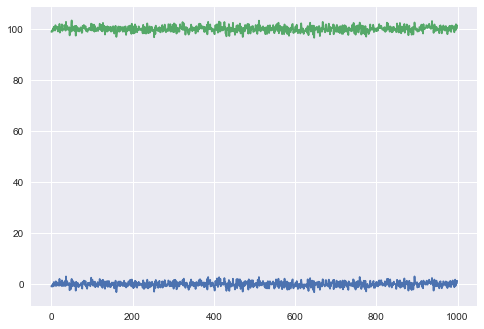

In [77]:
plt.plot(range(1000), x, range(1000), y)

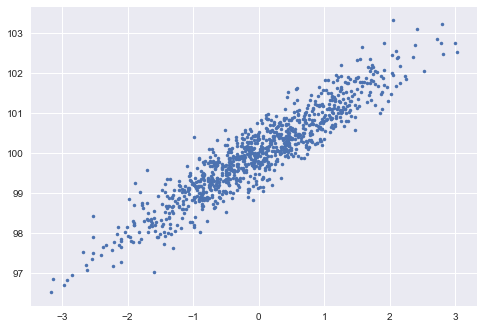

In [78]:
plt.plot(x, y, '.')

In [79]:
deltas = []
for i in range(1000):
    x_s = np.copy(x)
    np.random.shuffle(x_s)
    delta_1 = (x_s - y).mean()
    deltas.append(delta_1)
    
delta_0 = (x - y).mean()

In [80]:
deltas = np.array(deltas)

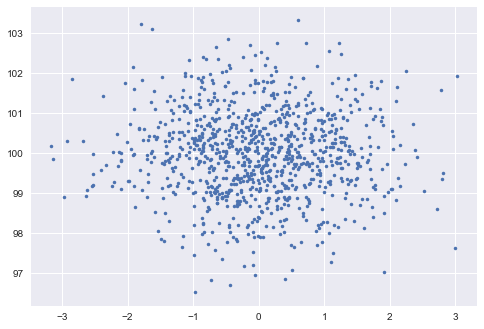

In [81]:
plt.plot(x_s, y, '.')

In [82]:
print(delta_0)
print(np.std(deltas))

-99.9983794181
2.16919282856e-14


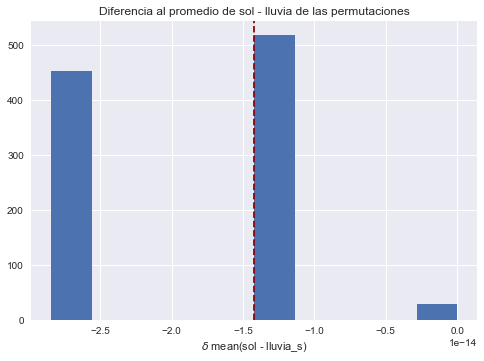

In [83]:
plt.hist(deltas - np.mean(deltas))
plt.axvline(delta_0 - np.mean(deltas), color='darkred', linestyle='--', label='valor muestra')
plt.title('Diferencia al promedio de sol - lluvia de las permutaciones')
plt.xlabel(r'$\delta$ mean(sol - lluvia_s)')